This notebook explore the result of the survey

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from io import StringIO
from IPython.core.display import HTML
from pathlib import Path
from wordcloud import WordCloud

In [2]:
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199
# plt.style.use('seaborn-colorblind')
plt.rcParams.update({
    'font.size': 22, 
    "axes.facecolor" : "white", 
    'figure.autolayout': True}) # must set in top
plt.rcParams["figure.facecolor"] = 'w'
# plt.style.use("bmh")
# plt.rcParams.update({"figure.figsize" : (12, 8),
#                      "axes.facecolor" : "white",
#                      "axes.edgecolor":  "black"})

def store_fig(fig, name, path =  Path('../results/figures')):
    '''Store figure in pdf, png and svg in a folder

    :param fig: matplotlib figure object
    :param name: name of the figure to save
    :param path: Path objet to store generated plots
    '''
    main_path = path / Path(name)
    fig.savefig(path / Path(f"{name}.pdf"), bbox_inches="tight")
    fig.savefig(path / Path(f"{name}.png"), bbox_inches="tight")
    fig.savefig(path / Path(f"{name}.svg"), bbox_inches="tight")

In [3]:
spreadsheets_url = 'https://docs.google.com/spreadsheets/d/1Y64wOTosdQviRreLaHxPE2F55IAP4VsfNisMGaeDCSw/export?gid=0&format=csv'
data_dp = Path('../data/') 
modified_spreadsheets_path = data_dp / Path('modified_answers.csv')
spreadsheets_copy_path = data_dp / Path('survey_answers_copy.csv')

In [4]:
survey_df = (pd.read_csv(spreadsheets_url, index_col = None)
    .assign(
            date=lambda x: pd.to_datetime(x['Timestamp'], dayfirst=True)))
survey_df.head()

,Timestamp,Can you give a short description of your research area? \nE.g.: I investigate the microorganisms in marine habitats to try and understand how they adapt to changing climatic conditions.,What is your main target?,Which techniques do you use?,Which analysis do you use or would like to do?,"Which tools, platforms or databases are you using to conduct your research analyses (e.g. Anvi’o, RStudio, nr, etc.)?",How often do you use Galaxy?,"If you never or rarely use Galaxy, what are the reasons?",Which Galaxy server(s) do you use?,Which tools and databases do you think are missing in Galaxy?,"What features, tools, workflows etc. would you like to have in Galaxy that would support your research?",Which training resources are you using?,Which country are you based in?,What is your career stage?,Would you be interested in being contacted by the microGalaxy team and contributing an example use case to a manuscript?,"If the tools, platforms or databases from the previous question could be deployed in Galaxy would use prefer to use in there?",date
0,17/03/2023 09:10:05,Microbila analysis,Bacteria,"Amplicon / metabarcoding, Metagenomics, Metatr...","Taxonomic Profiling, Pathogen Tracking, Assemb...","deepmicro, fastQC, kraken2, Trimmomatics, SPAd...",Daily,NaN,"Galaxy Europe, Local Instance",Bracken (pluspf) broken,NaN,All from: metagenomics,Germany,Postdoctoral researcher,No,NaN,2023-03-17 09:10:05
1,21/03/2023 13:52:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,2023-03-21 13:52:36
2,21/03/2023 16:31:47,NaN,Bacteria,Single organism genomics,"Pathogen tracking, Assembly, Antimicrobial res...",NaN,Weekly,NaN,"Galaxy Europe, usegalaxy.eu, Galaxy Australia,...",Panario/pangolin for pangenome analyses\nGWAS ...,A clear trycycler workflow!,NaN,Italy,Postdoctoral researcher,Yes,Yes,2023-03-21 16:31:47
3,21/03/2023 17:37:24,Microbe-microbe interaction for biocontrol app...,Eukaryotes,"Single organism genomics, Single organism tran...","Assembly, Functional analysis, Gene identifica...","Galaxy, JGI mycocosm, NCBI, R,",Weekly,NaN,"Galaxy Europe, usegalaxy.eu","Whole genome phylogeny, better usability for c...","Whole genome phylogeny, metabolite analysis fr...",Galaxy help boards,China,Principal Investigator,Yes,Yes,2023-03-21 17:37:24
4,22/03/2023 00:12:15,"I work purely on infrastructure services, but ...",Mixed Communities,"Single organism transcriptomics, Amplicon / me...","Taxonomic profiling, Pathogen tracking, Antimi...",basic Galaxy stuff only,Several times per year,I used to use Galaxy daily during a part of th...,"Galaxy Europe, usegalaxy.eu, Galaxy Norway, us...","Not enough knowledge to answer this, sorry 🙁",A dream: Some microbiome/microbial wizard trul...,"None recently, sadly no capacity :(",Norway,"Oh no, we forgot to include technical position...",No,NaN,2023-03-22 00:12:15


Number of answers

In [5]:
len(survey_df.index)

129

Evolution of answers over time:

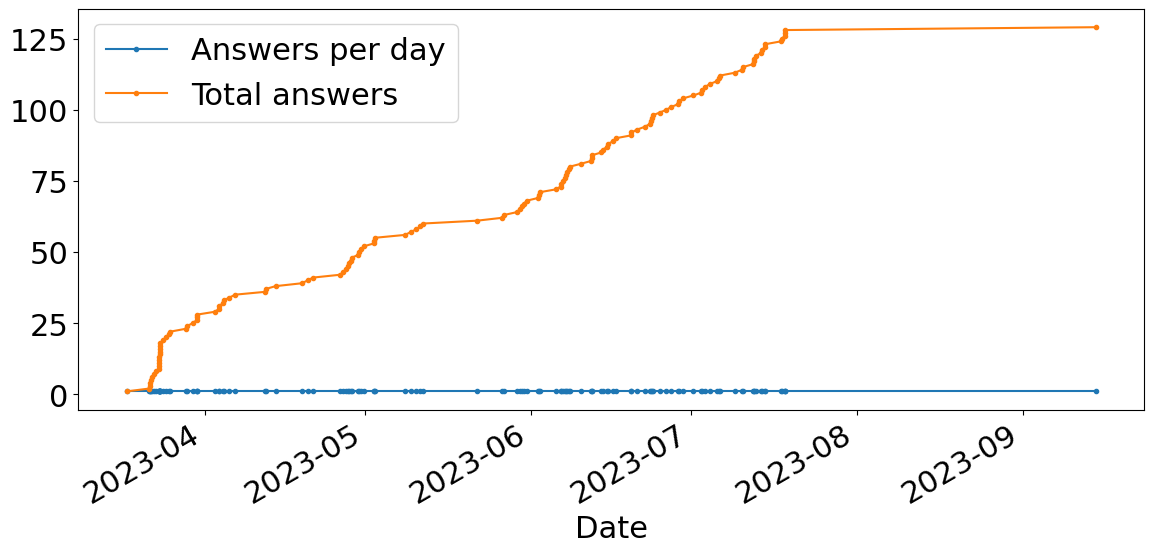

In [6]:
group = (survey_df.groupby("date")
         .count()
         .filter(['Timestamp'])
         .rename(columns = {"Timestamp": "Answers per day"}))
group["Total answers"] = group["Answers per day"].cumsum()

fig, ax = plt.subplots(figsize = (12,6))
group.plot(ax = ax, style='.-')
ax.set_xlabel("Date")
store_fig(fig, "survey_course")

Create an modifiable version of the responses, which is updated with new rows if a row is added to the original, the modifiable version can be used to clean the data and add additional columns 

In [ ]:
mod_response_df

In [ ]:
mod_response_df = pd.read_csv(modified_spreadsheets_path, index_col = 0)
mod_response_df = mod_response_df.add_suffix('_mod')
#print(mod_response_df.index)

response_df_merged = pd.concat([response_df, mod_response_df], axis = 1)
#print(response_df_merged)

updated_mod_response_df = response_df_merged.loc[:,mod_response_df.columns]
updated_mod_response_df.columns = updated_mod_response_df.columns.str.replace("_mod","")
updated_mod_response_df.to_csv(modified_spreadsheets_path)

print("The following rows need to be added to the modified answers:", updated_mod_response_df[updated_mod_response_df['Timestamp'].isna()].index)
updated_mod_response_df = updated_mod_response_df[updated_mod_response_df['Timestamp'].notna()]

# Targets

In [7]:
group_dfs = {}

In [163]:
def prepare_question_counts(response_df, question, to_replace):
    '''Prepare counts for a specific question

    :param response_df: dataframe with all survey answers
    :param question: string with the question or column name to extract
    :param to_replace: dictionary with string to replace in the answers to question
    '''
    question_answers = response_df.loc[:,question]
    print(question_answers)
    for to_replace, value in to_replace.items():
        question_answers = question_answers.replace(to_replace, value, regex=True)

    print(question_answers)
    
    counts = (pd.DataFrame(
            question_answers    
                .str
                .get_dummies(sep=', ')
                .sum())
        .rename(columns={0: 'responses'})
        .sort_values('responses'))
    counts['percentage'] = (100*counts["responses"]/counts["responses"].sum()).round(2)

    return counts

def plot_question_counts(count_df, question, name):
    '''Generate plots with counts for question answer

    :param count_df: dataframe with 2 columns (responses, percentage)
    :param question: string with the question
    :param name: string for the plot files
    '''

    fig, ax = plt.subplots(figsize = (12,6))

    count_df.plot.barh(ax = ax, y = "responses")
    
    for p, val in zip(ax.patches, count_df['percentage']):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{val:.2f}%', (x + width + 4, y + 0.1), ha='center')
    
    #ax.set_xticks(np.arange(0, 60, 5))
    ax.set_xlabel("Number of responses")
    ax.set_title(question)
    ax.get_legend().remove()
    
    store_fig(fig, name)

## Organism targets

In [128]:
question = "What is your main target?"
question

'What is your main target?'

In [129]:
to_replace = {
    "Viruses": "Virus",
    "and Fungal pathogens ": "Fungi",
    "Mice model": "Mixed Communities",
    "Human": "Mixed Communities",
    "Amoebas \(Plasmodium falciparum\)": "Eukaryotes",
    "plants": "Plants",
    " Nonmodel plant species": "Plants",
    "Parasites \(Protozoa, Helminths\)": "Eukaryotes",
    "Metagenomics": "Mixed Communities"
}
count_df = prepare_question_counts(survey_df, question, to_replace)
group_dfs['Main target'] = count_df
count_df

,responses,percentage
Fungi,2,1.63
Plants,2,1.63
Virus,8,6.50
Mixed Communities,27,21.95
Eukaryotes,30,24.39
Bacteria,54,43.90


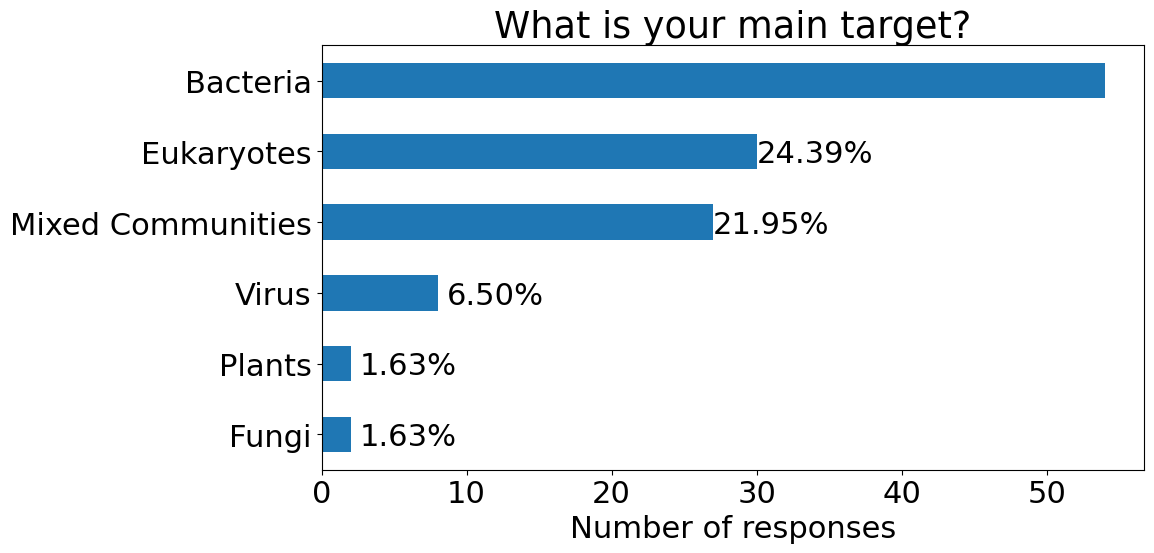

In [130]:
plot_question_counts(count_df, question, 'organism_target')

## Technical target

In [131]:
question = "Which analysis do you use or would like to do?"
question

'Which analysis do you use or would like to do?'

In [132]:
to_replace = {
    "Taxonomic Profiling": "Taxonomic profiling",
    #"Metagenomic analysis": "Taxonomic profiling",
    "MAGs building": "Metagenome assembled genome (MAG) building",
    "MAGs building": "Metagenome assembled genome (MAG) building",
    "Single nucleotide polymorphism \(SNP\) identification": "Single nucleotide polymorphism (SNP) / Multilocus sequence typing (MLST)",
    "SNP identification": "Single nucleotide polymorphism (SNP) / Multilocus sequence typing (MLST)",
    "Core genome MLST": "Single nucleotide polymorphism (SNP) / Multilocus sequence typing (MLST)",
    "Predictive Metagenomics": "Predictive metagenomics",
    "Functional Analysis": "Functional analysis",
    "Pathogen Tracking": "Pathogen tracking",
    "Antimicrobial resistance detection": "Antimicrobial resistance (AMR) detection",
    #"whole genome assembly": "Assembly",
    " Transcriptome assembler": "Assembly",
    "lefse": "Predictive metagenomics",
    "Metagenomic analysis and whole genome assembly and analysis": "Taxonomic profiling, Assembly",
    "bacterial Genome Wide Association Studies \(GWAS\)": "Other",
    "Characterising phage genomes": "Other" 	
        #"and ": ', '
}
count_df = prepare_question_counts(survey_df, question, to_replace)
group_dfs['Technical target'] = count_df
count_df

,responses,percentage
Other,2,0.32
Predictive metagenomics,23,3.66
Combination of multiomic approaches,31,4.93
Metagenome assembled genome (MAG) building,34,5.41
Pathogen tracking,37,5.88
Antimicrobial resistance (AMR) detection,46,7.31
Single nucleotide polymorphism (SNP) / Multilocus sequence typing (MLST),48,7.63
Taxonomic profiling,57,9.06
Phylogenetic tree construction,59,9.38
Comparative analyses,64,10.17


/var/folders/k_/5472klmd4fdb_wdkwgm7_n8m0000gp/T/ipykernel_72148/2827189984.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(path / Path(f"{name}.pdf"), bbox_inches="tight")
/var/folders/k_/5472klmd4fdb_wdkwgm7_n8m0000gp/T/ipykernel_72148/2827189984.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(path / Path(f"{name}.png"), bbox_inches="tight")
/var/folders/k_/5472klmd4fdb_wdkwgm7_n8m0000gp/T/ipykernel_72148/2827189984.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(path / Path(f"{name}.svg"), bbox_inches="tight")
/Users/bebatut/miniconda3/envs/microgalaxy_user_paper/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Tight layout not applied. The left and right m

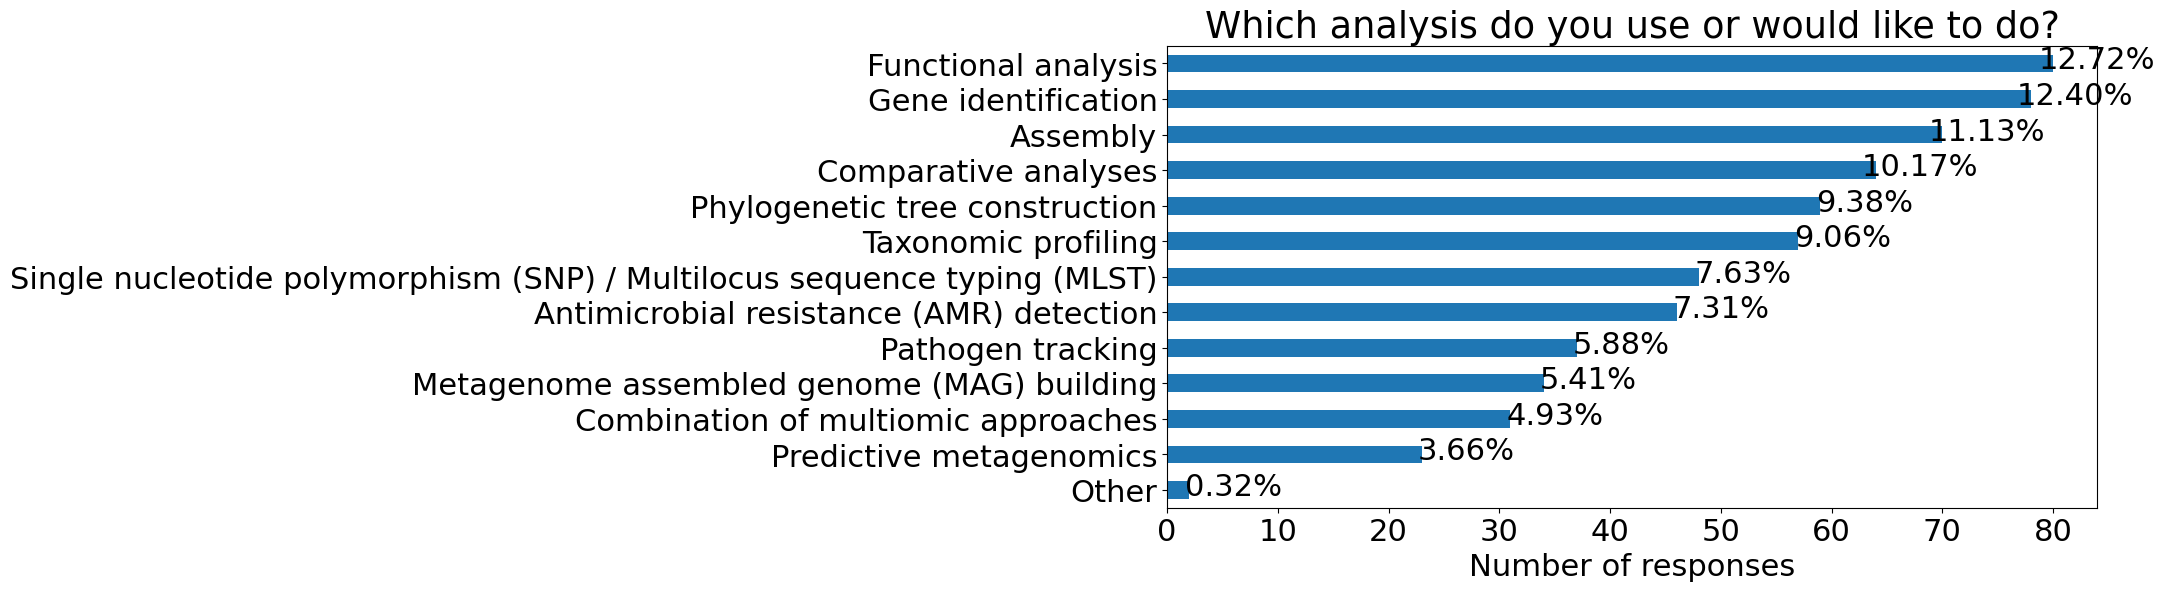

In [133]:
plot_question_counts(count_df, question, 'technical_target')

## Methods

In [134]:
question = "Which techniques do you use?"
question

'Which techniques do you use?'

In [135]:
to_replace = {
    "Metatranscriptomics": "Transcriptomics or metatranscriptomics",
    "Whole genome sequencing": "Single organism genomics",
    "chip-seq": "Other",
    "genome comparison": "Other", 
    "SELEX": "Other",
    "pan-genome analyses": "Other",
    "I am trying to learn! Mostly outsourced to service providers but need to learn as I have observed inconsistent results ": "Other",
    "Metabarcoding": "Amplicon / metabarcoding",
    "Machine learning models": "Other",
    "MD Simulations": "Other",
    "Drug discovery ": "Other"
}
count_df = prepare_question_counts(survey_df, question, to_replace)
group_dfs['Methods'] = count_df
count_df

,responses,percentage
Other,8,3.00
Metabolomics,9,3.37
Proteomics or metaproteomics,21,7.87
Amplicon / metabarcoding,37,13.86
Single organism transcriptomics,37,13.86
Transcriptomics or metatranscriptomics,39,14.61
Metagenomics,57,21.35
Single organism genomics,59,22.10


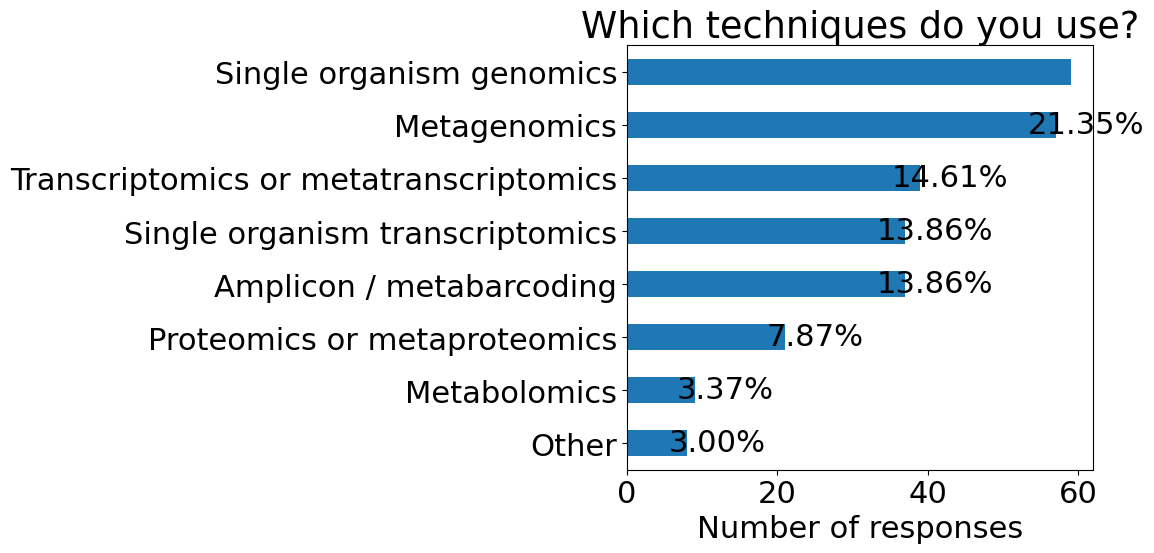

In [136]:
plot_question_counts(count_df, question, 'methods')

## All together

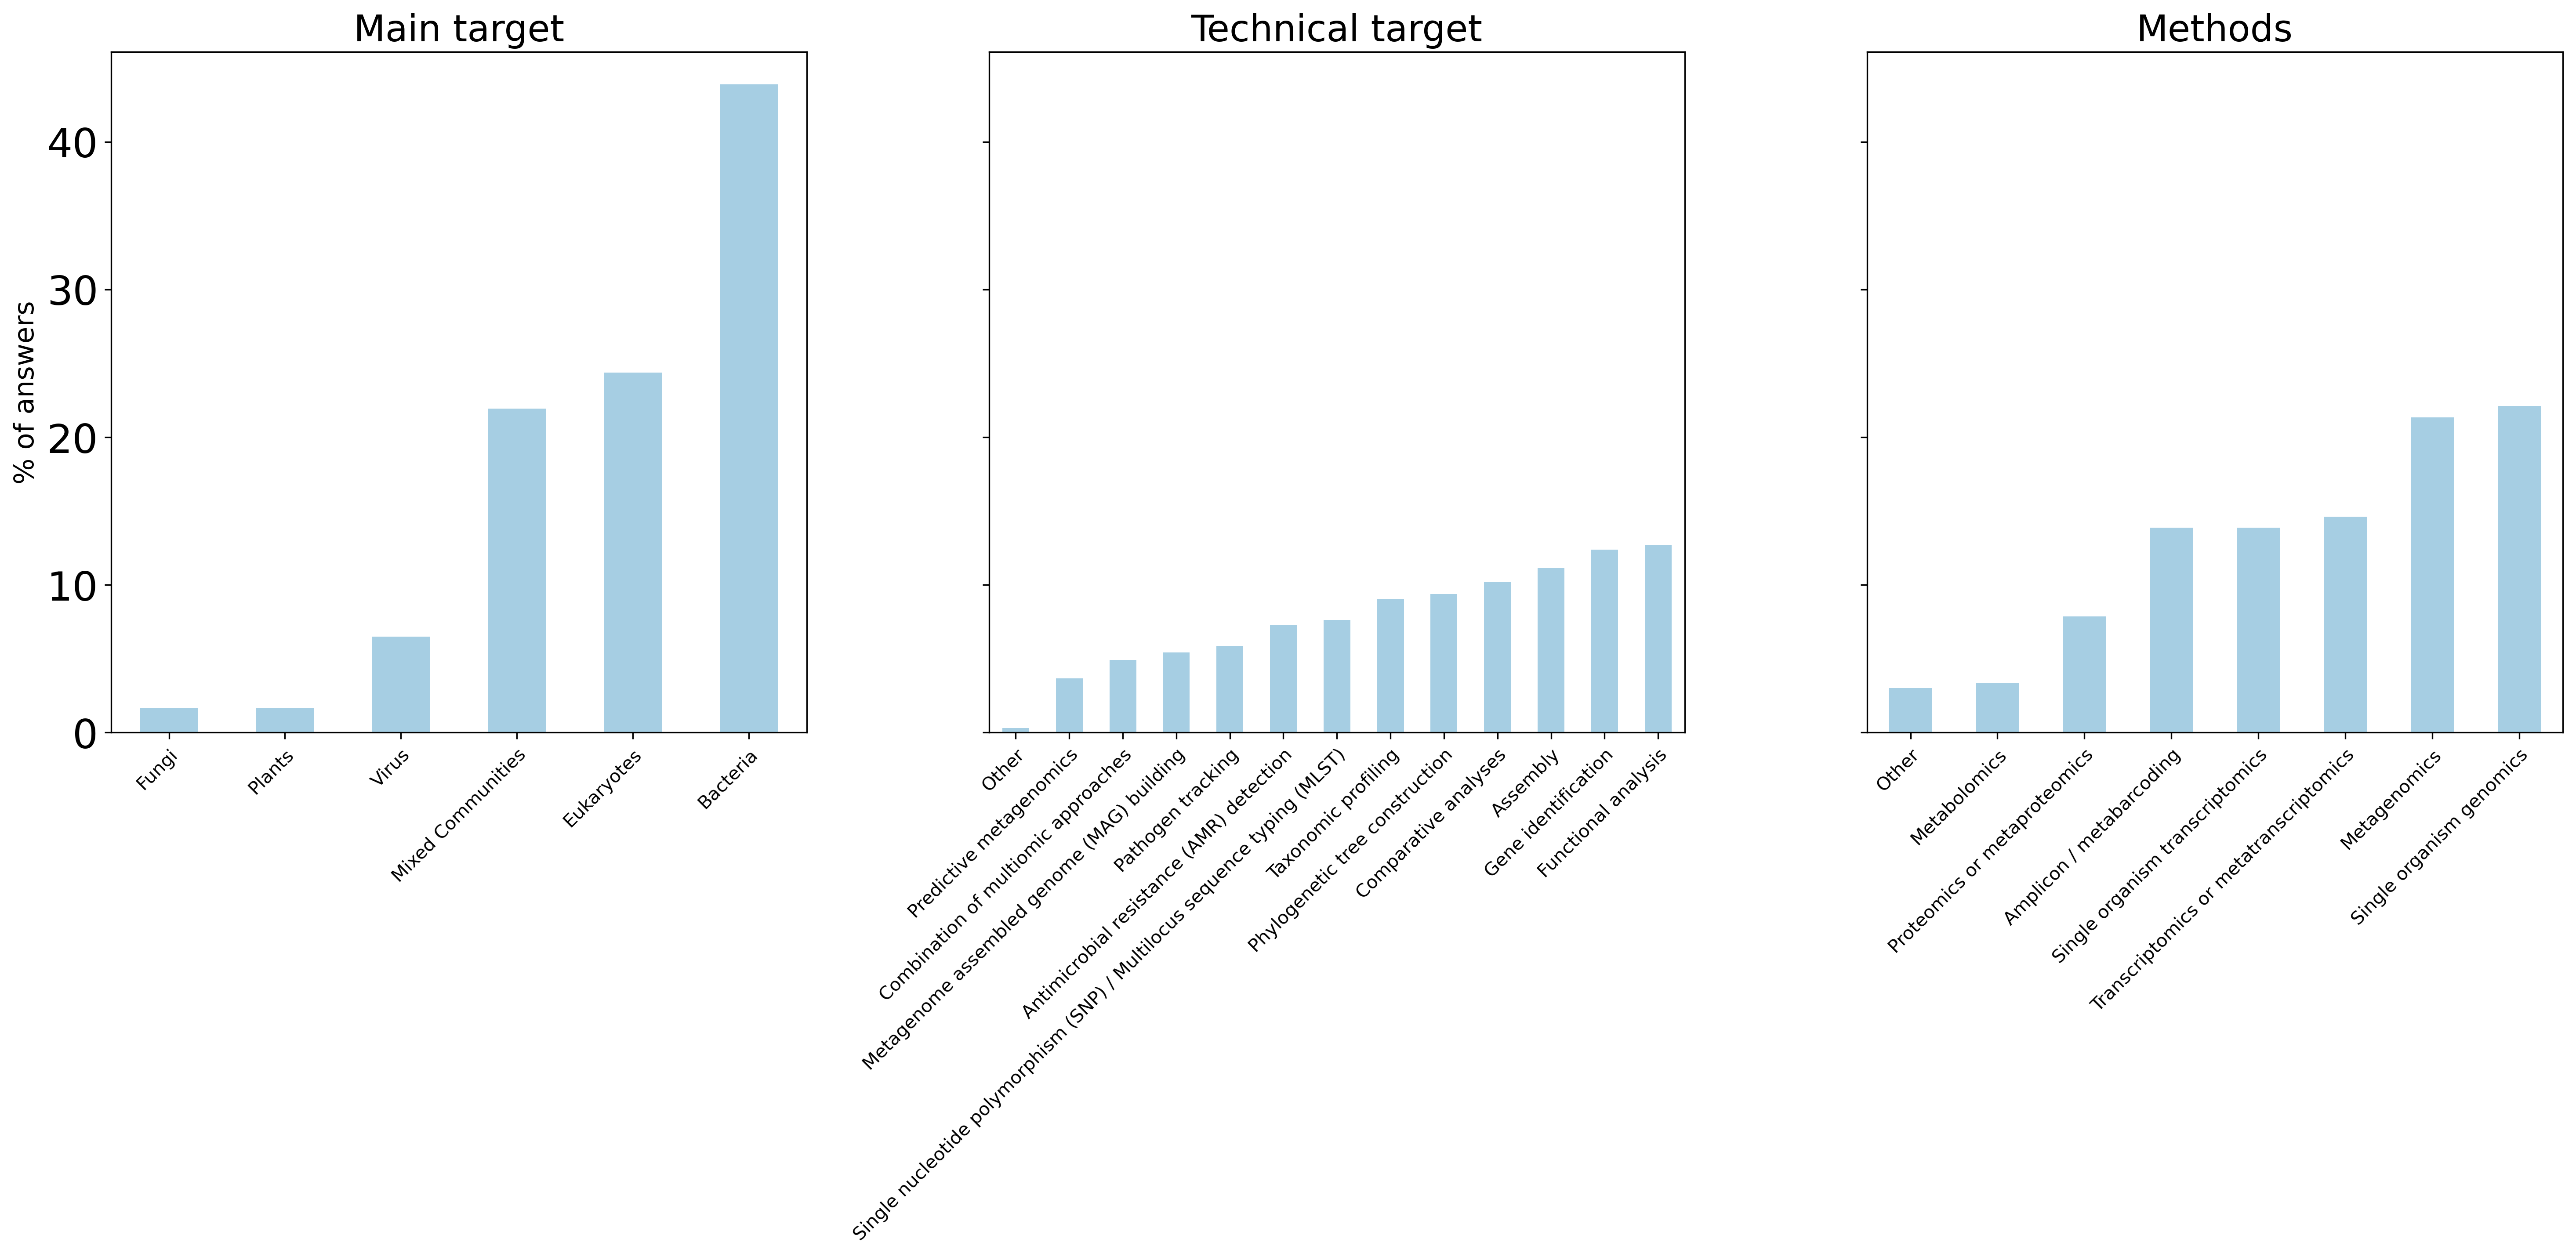

In [57]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 10))
fig.set_dpi(300)
for i, group in enumerate(group_dfs):
    (group_dfs[group].percentage
         .plot.bar(ax=axs[i], colormap='Paired'))
    #plt.xticks(rotation=45, ha='right')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=10)
    axs[i].set_title(group, fontsize=20)
axs[0].set_ylabel('% of answers', fontsize=15)
store_fig(fig, 'all_targets')

# Usage

## Tools, platforms or databases

In [160]:
question = "Which tools, platforms or databases are you using to conduct your research analyses (e.g. Anvi’o, RStudio, nr, etc.)?"
question

'Which tools, platforms or databases are you using to conduct your research analyses (e.g. Anvi’o, RStudio, nr, etc.)?'

In [172]:
to_replace = {
    # Platforms
    #"^R$": "R/RStudio",
    " R, Rstudio": " R/RStudio",
    " R, ": " R/RStudio, ",
    "(Rstudio and pythonRstudio and Python)": "R/RStudio, Python",
    "(RStudios and webservers|Rstudio|R studio|R-studio|RStudio)": "R/RStudio",
    "Resfinder": "ResFinder",
    "BioPython": "Python",
    "Biopython": "Python",
    'Python libraries': "Python",
    "python": "Python",
    "Command line w/ ": "Command-line",
    "awk": "Command-line",
    "Bash": "Command-line",
    "Linux shell": "Command-line",
    "Varios tools via conda": "Command-line",
    "Unix": "Command-line",
    "galaxy europe": "Galaxy",
    "basic Galaxy stuff only": "Galaxy",
    "usegalaxy": "Galaxy",
    "galaxy": "Galaxy",
    "Galaxy FROGS": "Galaxy",
    "EBI MGnify pipelin version 5.": "MGnify",
    "JGI mycocosm": "JGI Mycocosm",
    "Anvio": "Anvi'o",
    "JGI": "JGI Genome Portal",
    "Tools: ": "",
    "terrabio": "Terra.Bio",
    "MP3 server": "MP3",
    "BVBRC": "BV-BRC",
    # Tools
    ##".": ", "
    "SPAdes": "(meta)SPAdes",
    "spades": "(meta)SPAdes",
    "metaspades": "(meta)SPAdes",
    "metaphlan2": "MetaPhlAn",
    "Metaphlan": "MetaPhlAn",
    "skesa": "SKESA",
    "Humann": "HUMAnN",
    "humann2": "HUMAnN",
    "HUMAMNN": "HUMAnN",
    "kraken2": "Kraken",
    "kraken": "Kraken",
    "braken": "Braken",
    "Mr Beyes": "MrBayes",
    "deepmicro": "DeepMicro", 
    "fastQC": "FastQC", 
    "cutadapt": "Cutadapt",
    "Phylobayes": "PhyloBayes", 
    "Mantis": "mantis", 
    "IQtree2": "IQ-TREE",
    "QIIME2": "QIIME",
    "EDGE": "EdgeR",
    "Clustal-o \(EMBL-EBI, local\)": "Clustal, EMBL-EBI, Command-line",
    "FLye/metaflye": "(meta)Flye",
    "BLASTn": "BLAST",
    "prokka": "Prokka",
    "bowtie": "Bowtie",
    "fastqc": "FastQC",
    "ChewBBACA": "chewBBACA",
    "confindr": "ConFindr",
    "grapetree": "GrapeTree",
    "phyloseq and picrust2 pipeline via command line": "phyloseq, PICRUSt, Command-line",
    "Proteome discoverer\.": "Proteome Discoverer",
    "MAASLIN": "MaAsLin",
    "Vmd": "VMD",
    "Autodock and gromacs": "AutoDock, GROMACS", 
    "manta": "Manta",
    ## Databases
    #" nr": " RefSeq",
    "^nr$": " RefSeq",
    "genebank viruses": "GenBank virus",
    "pfam": "PFAM",
    "RSA\(NCBI\)": "SRA",
    "PATRIC db \(BV-BRC\)": "PATRIC",
    "Databases: various NCBI databases, most heavily SRA.": "NCBI",
    "ncbi and ena": "NCBI, ENA",
    "ncbi": "NCBI",
    "GO databases": "GO",
    "Resfinder": "ResFinder",
    "Bacmet": "BacMet",
    "treebase": "TreeBASE",
    ## Other
    "etc\.": "Other",
    "etc": "Other",
    " Decontamination tools": "",
    " Bioinformatcs tools: many of the standard tools for processing both genomic and metagenomic data from illumina, oxford, and pacbio sequencers. Heavily used tools include ": "",
    "-": "",
    "NA": "",
    ", Apple Mac": "",
    "Nothing": "",
    "\.\.\.": ""
}
platforms = ["R/RStudio", "Command-line", "Python", "Galaxy", "Matlab", "MGnify", "RAST", "PathogenWatch", "JGI Mycocosm", "Anvi'o", 
             "JGI Genome Portal", "BV-BRC", "Terra.Bio", "Jupyter", "MEGAN", "EMBL-EBI", "MP3", "KBase", "Geneious", "CLC Genomics Workbench",
             "PathogenWatch"]
tools = ["(meta)SPAdes", "MetaPhlAn", "HUMAnN", "Kraken", "MrBayes", "RaxML", "RSEM", "PyMOL", "Proteome discoverer", 
         "ScaFos", "Prokka", "Perseus", "DeepMicro", "Braken", "virAnnot", "ete3", "PhyloBayes", "mantis", "SKESA", "CFSAN SNP Pipeline", 
         "Artemis", "Trinity", "IQ-TREE", "QIIME", "EdgeR", "MEGAN", "MEGA", "Clustal", "BLAST", "BWA", "Bowtie", "FastQC", "MaxQuant", 
         "chewBBACA", "ConFindr", "GrapeTree", "phyloseq", "PICRUSt", "snippy", "DADA2", "BEAST", "abricate", "Proteome Discoverer", 
         "InterProScan", "VMD", "NAMD", "MaAsLin", "AutoDock", "GROMACS", "IGB", "PyMOL", "ARTIC", "ANCOM", "RSEM", "Manta"]
databases = ["RefSeq", "SRA", "PATRIC", "PFAM", "GenBank virus", "KEGG", "NCBI", "SilVA", "GO", "CARD", "ResFinder", "BacMet", "TreeBASE"]
count_df = prepare_question_counts(survey_df, question, to_replace)
count_df

0      deepmicro, fastQC, kraken2, Trimmomatics, SPAd...
1                                                    NaN
2                                                    NaN
3                        Galaxy, JGI mycocosm, NCBI, R, 
4                                basic Galaxy stuff only
                             ...                        
124                                                  NaN
125                                       RStudio, QIIME
126                                                  NaN
127                                                  NaN
128                                                  NaN
Name: Which tools, platforms or databases are you using to conduct your research analyses (e.g. Anvi’o, RStudio, nr, etc.)?, Length: 129, dtype: object
0      DeepMicro, FastQC, Kraken, Trimmomatics, (meta...
1                                                    NaN
2                                                    NaN
3      Galaxy, JGI Genome Portal Mycocosm, NCBI, R

,responses,percentage
KBase,1,0.43
PyMOL,1,0.43
PhyloBayes,1,0.43
Perseus,1,0.43
PathogenWatch,1,0.43
...,...,...
Commandline,6,2.61
NCBI,6,2.61
Python,10,4.35
Galaxy,15,6.52


In [114]:
def index_filter_counts(count_df, indices):
    '''Filter the count table based on list of indices and recompute percentage

    :param count_df: count dataframe to filter
    :param indices: list of indices to keep
    '''
    subcount_df = (count_df[count_df.index.isin(indices)]
        .drop(columns=['percentage']))
    subcount_df['percentage'] = (100*subcount_df["responses"]/subcount_df["responses"].sum()).round(2)
    return(subcount_df)

In [174]:
count_df[~count_df.index.isin(platforms + tools + databases)]

,responses,percentage
KBase,1,0.43
PEMA,1,0.43
Notepad,1,0.43
NCBI R/R/RStudio,1,0.43
MGnify,1,0.43
MD,1,0.43
MANTA,1,0.43
R/RStudio,1,0.43
R/RStudio. Proteome Discoverer,1,0.43
meta(meta)SPAdes,1,0.43


### Platforms

In [142]:
plaftorm_df = index_filter_counts(count_df, platforms)
plaftorm_df

,responses,percentage
RAST,1,1.69
PathogenWatch,1,1.69
Matlab,1,1.69
MGnify,1,1.69
Command-line,2,3.39
Python,9,15.25
Galaxy,14,23.73
R/RStudio,30,50.85


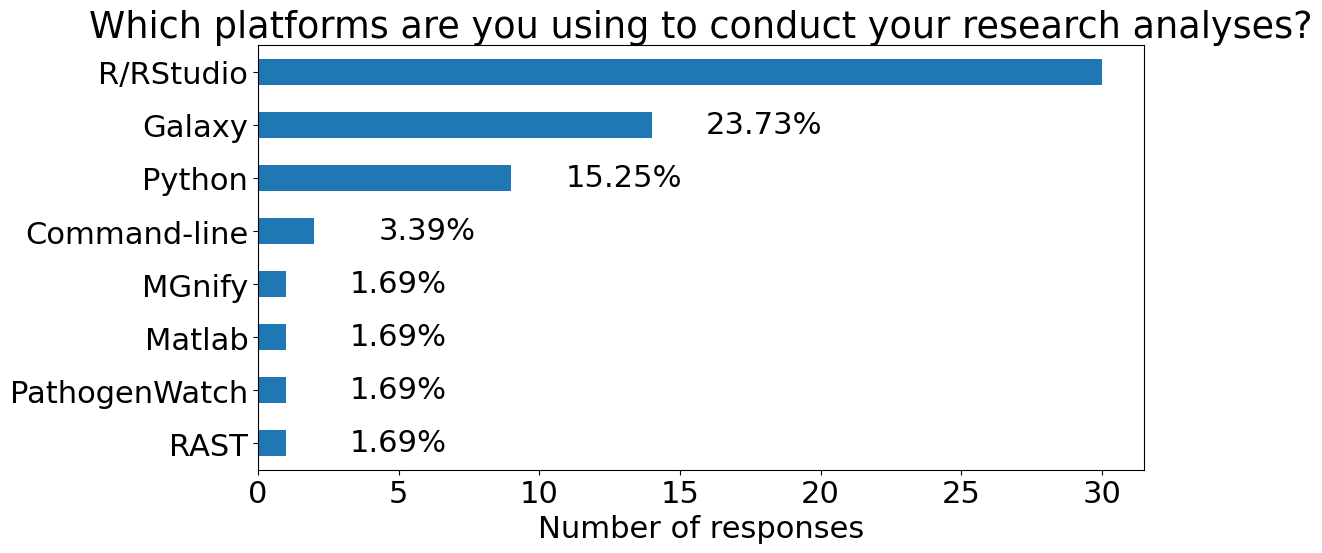

In [143]:
plot_question_counts(plaftorm_df, "Which platforms are you using to conduct your research analyses?", 'platform')

### Tools

In [144]:
tool_df = index_filter_counts(count_df, tools)
tool_df

,responses,percentage
MrBayes,1,5.88
Samtools,1,5.88
RaxML,1,5.88
RSEM,1,5.88
PyMOL,1,5.88
Proteome discoverer,1,5.88
ScaFos,1,5.88
Prokka,1,5.88
Perseus,1,5.88
Kraken,1,5.88


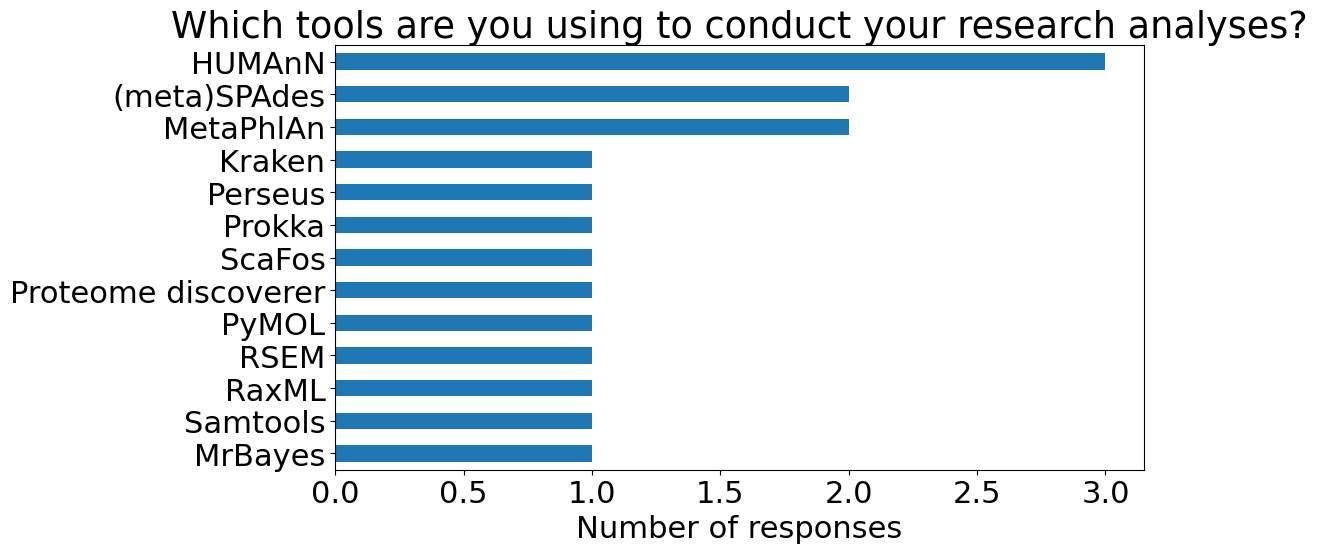

In [145]:
plot_question_counts(tool_df, "Which tools are you using to conduct your research analyses?", 'tools')

Comparison with microGalaxy tool list

### Databases

In [146]:
db_df = index_filter_counts(count_df, databases)
db_df

,responses,percentage
RefSeq,1,50.0
PATRIC,1,50.0


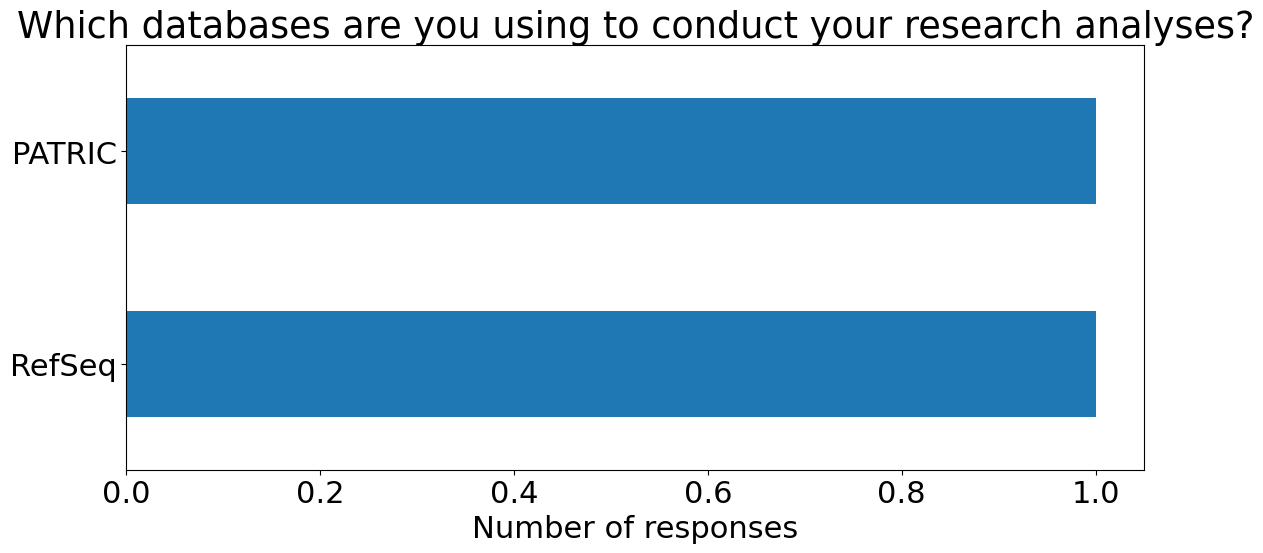

In [147]:
plot_question_counts(db_df, "Which databases are you using to conduct your research analyses?", 'database')

In [ ]:
# tools
question = "Which tools, platforms or databases are you using to conduct your research analyses (e.g. Anvi’o, RStudio, nr, etc.)?"
sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")
fig, ax = plt.subplots(figsize = (12,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 1, y), ha='center')

ax.set_xticks(np.arange(0, 50, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Which tools, platforms or databases are you using to conduct your research analyses ?")
ax.get_legend().remove()

store_fig(fig, "tools")


In [ ]:
text_df = sub_df.dropna()
vals = []
for val in text_df:
    for v in val.split(','):
        vals.append(v.strip(' '))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(vals))

fig, ax = plt.subplots(figsize = (16,8))


ax.imshow(wordcloud)
ax.set_title("Which tools, platforms or databases are you using to conduct your research analyses ?",pad=40)
plt.axis("off")

fig.tight_layout()
# fig.savefig('figures/tools_DBs_used_for_research_wordcloud.png')
plt.show()

store_fig(fig, "tools_wordcloud")

In [ ]:
# How many of the used tools are in galaxy ?

tools_in_galaxy = updated_mod_response_df.loc[:,"In Galaxy"].sum()
tools_not_galaxy = updated_mod_response_df.loc[:,"Not in Galaxy"].sum()

labels = ['Tools in Galaxy', 'Tools not in Galaxy']
sizes = [tools_in_galaxy, tools_not_galaxy]

# fig, ax = plt.subplots(figsize = (15,8))
# merged_df.plot.barh(ax = ax, y = "Responses")

# for p, val in zip(ax.patches, merged_df["Responses"]):
#     width = p.get_width()
#     height = p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate(f'{val}', (x + width + 0.6, y + 0.2), ha='center')

# ax.set_xticks(np.arange(0, 15, 5))
# ax.set_xlabel("Number of responses")
# # ax.set_ylabel("Answer")
# ax.set_title("Availability of tools in Galaxy")
# ax.get_legend().remove()

# store_fig(fig, "tools_in_galaxy_bar")

##############################################################

fig, ax = plt.subplots(figsize = (10,10))
# fig, ax = plt.subplots(ax = ax, facecolor='w')
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.set_title("Availability of tools in Galaxy")

store_fig(fig, "tools_in_galaxy")

## Galaxy

In [ ]:
question = "How often do you use Galaxy?"

sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.value_counts()
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (15,8))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.6, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("How often do you use Galaxy?")
ax.get_legend().remove()

store_fig(fig, "how_often_use_galaxy_bar")

##################################################

# fig, ax = plt.subplots(figsize = (10,10))
# merged_df.plot.pie(ax = ax, y = "Responses", legend=False, autopct= '%.1f%%')
# ax.set_title("How often do you use Galaxy?")

# ax.set_facecolor("white")
# ax.set_ylabel('')

# store_fig(fig, "how_often_use_galaxy")

### Reason for not using Galaxy

In [ ]:
# tools
question = "Galaxy Obstacles"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (12,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.2, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("If you never or rarely use Galaxy, what are the reasons?")
ax.get_legend().remove()

store_fig(fig, "reasons_no_use")

### Galaxy server(s)

In [ ]:
response_df, response_df_merged = update_mod_sheet()
question = "Which Galaxy server(s) do you use?"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

drop_instance = ["Galaxy Europe", "Main", "Galaxy Australia", "Galaxy Norway", "Galaxy France"]

print(sub_df_count.index.isin(drop_instance))

sub_df_count = sub_df_count[~sub_df_count.index.isin(drop_instance)]
print(sub_df_count)

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (12,10))
merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 2.5, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 80, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Which Galaxy server(s) do you use?")
ax.legend(loc="lower right")
ax.get_legend().remove()

store_fig(fig, "server")

### Which tools and databases do you think are missing in Galaxy?

In [ ]:
#TODO
response_df, updated_mod_response_df = update_mod_sheet()

question = "Missing tools ?"
sub_df = updated_mod_response_df.loc[:,question]

text_df = sub_df.dropna()
vals = []
for val in text_df:
    for v in val.split(','):
        vals.append(v.strip(' '.replace(" ","~")))

print(','.join(vals))

# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(','.join(vals))
wordcloud = WordCloud(width=800, height=400, background_color='white', regexp=r"[ \w]+", collocations=False).generate(','.join(vals))

fig, ax = plt.subplots(figsize = (16,8))

ax.imshow(wordcloud)
ax.set_title("Which tools and databases do you think are missing in Galaxy?",pad=40)
plt.axis("off")

fig.tight_layout()
store_fig(fig, "tools_missing_wordcloud")
plt.show()

In [ ]:

wordcloud = WordCloud(width=800, height=400, background_color='white', regexp=r"[ \w]+", collocations=False).generate("Foo Bar\nFoo Bar\n bla\n")

fig, ax = plt.subplots(figsize = (16,8))

ax.imshow(wordcloud)
ax.set_title("Which tools and databases do you think are missing in Galaxy?",pad=40)
plt.axis("off")

fig.tight_layout()
store_fig(fig, "tools_missing_wordcloud")
plt.show()

### If the tools, platforms or databases from the previous question could be deployed in Galaxy would use prefer to use in there?

In [ ]:
question = "If the tools, platforms or databases from the previous question could be deployed in Galaxy would use prefer to use in there?"

sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.value_counts()
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
# sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
# merged_df = merged_df.drop(sliced_merged_df.index)

fig, ax = plt.subplots(figsize = (10,5))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 2, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 80, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("If the features (e.g. tools) where available \nin galaxy would you use it ?")
ax.get_legend().remove()
store_fig(fig, "continent_bar")

#############################################################

fig, ax = plt.subplots()
merged_df.plot.pie(ax = ax, y = "Responses", figsize=(14,8), legend=False, autopct= '%.1f%%')
ax.set_title("If the features (e.g. tools) where in galaxy would you use it ?")

ax.set_facecolor("white")
ax.set_ylabel('')

store_fig(fig, "use_it_pie")

## Training resources

In [ ]:
# tools
response_df, response_df_merged = update_mod_sheet()
question = "Training resources?"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (14,8))
merged_df.plot.barh(ax =  ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.2, y + 0.1), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Which training resources are you using?", pad=20)
ax.get_legend().remove()

store_fig(fig, "resources")

# Demography

## Localization

In [ ]:
# tools
response_df, updated_mod_response_df = update_mod_sheet()
question = "Which country are you based in?"

sub_df = updated_mod_response_df.loc[:,question]

# get count
sub_df_count = sub_df.str.get_dummies(sep=', ').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (14,16))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 0.2, y ), ha='center')

ax.set_xticks(np.arange(0, 15, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title(question)
ax.get_legend().remove()

store_fig(fig, "country")

In [ ]:
# continent

import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

response_df, updated_mod_response_df = update_mod_sheet()
question = "Which country are you based in?"

sub_df = updated_mod_response_df.loc[:,question]

def convert_to_continent(val):

    new_val = []
    for v in val.split(','):
        v = v.strip(' ')
        try:
            v = country_to_continent(v)
        except:
            v = 'Unknown'
        new_val.append(v)
    new_val = ','.join(new_val)
    #print(val, new_val)
    return(new_val)    
    
sub_df = sub_df.dropna()
sub_df = sub_df.apply(convert_to_continent)

# get count
sub_df_count = sub_df.str.get_dummies(sep=',').sum() #convert multiple answers to counts
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 0)]
# others = sliced_merged_df.sum()
# others.name = "Others"
# merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

fig, ax = plt.subplots(figsize = (10,10))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 1, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 40, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title("Survey answer by continent.")
ax.get_legend().remove()
store_fig(fig, "continent_bar")

fig, ax = plt.subplots(figsize = (10,10))
ax = merged_df.plot.pie(ax = ax, y = "Responses", figsize=(12,8), legend=False, autopct= '%.1f%%')
ax.set_title("Survey answer by continent.")

ax.set_facecolor("white")
ax.set_ylabel('')

store_fig(fig, "continent_pie")

## Career stage

In [ ]:
question = "What is your career stage?"

sub_df = response_df.loc[:,question]

# get count
sub_df_count = sub_df.value_counts()
sub_df_count.name = "Responses"

# get percentage
merged_df = pd.DataFrame(sub_df_count)
merged_df['norm'] = merged_df["Responses"]/merged_df["Responses"].sum()
merged_df['norm'] = merged_df['norm'].round(2)

# merge low occurences into "Others"
sliced_merged_df = merged_df.loc[(merged_df["Responses"] == 1)]
others = sliced_merged_df.sum()
others.name = "Others"
merged_df = merged_df.append(others)
merged_df = merged_df.drop(sliced_merged_df.index)

#customize plot
merged_df = merged_df.sort_values(by = "Responses")

###################################################

fig, ax = plt.subplots(figsize = (12,8))
ax = merged_df.plot.barh(ax = ax, y = "Responses")

for p, val in zip(ax.patches, merged_df["Responses"]):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{val}', (x + width + 2, y + 0.2), ha='center')

ax.set_xticks(np.arange(0, 40, 5))
ax.set_xlabel("Number of responses")
# ax.set_ylabel("Answer")
ax.set_title(question)
ax.get_legend().remove()
store_fig(fig, "career_bar")

##################################################

fig, ax = plt.subplots(figsize = (10,10))
merged_df.plot.pie(ax = ax, y = "Responses", figsize=(12,8), legend=False, autopct= '%.1f%%')
ax.set_title(question)

ax.set_facecolor("white")
ax.set_ylabel('')
# ax.get_legend().remove()

store_fig(fig, "career_pie")